In [3]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT p.* FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara p
-- exclude non-standard CCG codes:
INNER JOIN ebmdatalab.hscic.ccgs c ON p.pct = c.code AND c.org_type = "CCG"
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

df1.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,pct,chemical,subpara,num,denom,ratio
0,00C,0101010C0,0101010,4,217,0.018433
1,00C,0101010G0,0101010,198,217,0.912442
2,00C,0101010L0,0101010,1,217,0.004608
3,00C,0101010R0,0101010,14,217,0.064516
4,00D,0101010G0,0101010,553,637,0.868132


## Clean the data: sort out null denominators

In [4]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph,, even if not prescribed.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - this will list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
data2.head()


,pct,subpara,denom_subpara,chemical,num,denom,ratio
0,00C,0101010,217.0,0101010C0,4.0,217.0,0.018433
1,00C,0101010,217.0,0101010G0,198.0,217.0,0.912442
2,00C,0101010,217.0,0101010L0,1.0,217.0,0.004608
3,00C,0101010,217.0,0101010R0,14.0,217.0,0.064516
4,00C,0101010,217.0,0101010J0,0.0,0.0,0.000000


### Filter out low numbers (chemical and subpara)

In [8]:
# total prescribing for each chemical
# sum numerators to find total volume for each chemical across all ccgs
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()

# calculate centile for numerator for each ccg
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))

# filter out CCGs with lowest denominator values
data3 = data3.loc[(data3["denom centile"]>2)]

# num of CCGs prescribing each chemical
count_ = pd.DataFrame(data3.loc[data3["num"]>0].groupby("chemical")["pct"].nunique()).reset_index()
count_ = count_.rename(columns={"pct":"count2"})

data3 = data3.merge(count_, how="inner", on="chemical")

data3.head()

,pct,subpara,denom_subpara,chemical,num,denom,ratio,num_total,num centile,denom_subpara_total,denom centile,count2
0,00C,0101010,217.0,0101010C0,4.0,217.0,0.018433,1423,5,39497.0,4,125
1,00D,0101010,637.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
2,00J,0101010,520.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
3,00K,0101010,321.0,0101010C0,16.0,321.0,0.049844,1423,5,39497.0,4,125
4,00L,0101010,322.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125


## Calculate key stats
### Median, Range, SD, Kurtosis and Skew

In [15]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count2"])["ratio"].describe())
#df2 = df2.unstack()
#df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","count2","50%","min","max","range","std"]].rename(columns={"50%":"median"})

# filter out chemicals in paragraphs only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]


# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")

# compile all stats together
result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","count2","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"]].round(2)

df4.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew
0,0501012G0,Flucloxacillin Sodium,0501012,Penicillinase-Resistant Penicillins,1058061.0,10,207.0,207.0,1.0,1.0,1.00,0.00,0.0,202.0,-14.28
1,0304010F0,Brompheniramine Maleate,0304010,Antihistamines,8.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
2,020400010,Pindolol With Diuretic,0204000,Beta-Adrenoceptor Blocking Drugs,1.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
3,120203000,Other Nasal Infection Preps,1202030,Nasal Prepn for Infection,2.0,1,207.0,1.0,0.0,0.0,0.01,0.01,0.0,202.0,14.28
4,1001030A0,Auranofin,1001030,Rheumatic Disease Suppressant Drugs,1.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28


## Ranking Chemicals by Range, Kurtosis, Skew and SD
Those with high range and SD tend to be chemicals where there is general disagreement, so outliers are not *that* unusual

In [30]:
# limit to those with positive skew, i.e. most CCGs prescribe few and those prescribing more are ouliers,
# and range at least 10%:

dfp = df4.loc[(df4["skew"]>=0) & (df4["range"]>0.1)]

# sort by range
r1 = dfp.sort_values(by=["range","kurtosis"],ascending=False)
# create a ranking
r1["R"]  = r1["range"].rank(ascending=False, method="min")

# sort by kurtosis 
r2 = dfp.sort_values(by=["kurtosis"],ascending=False)
r2["K"] = r2["kurtosis"].rank(ascending=False, method="min")

# sort by skew
r3 = dfp.sort_values(by=["skew"],ascending=False)
r3["Sk"] = r3["skew"].rank(ascending=False, method="min")

r1 = dfp.copy()
# create a ranking
r1["R"] = r1["range"].rank(ascending=False, method="min")
r1["K"] = r1["kurtosis"].rank(ascending=False, method="min")
r1["Sk"] = r1["skew"].rank(ascending=False, method="min")

#sort by SD
#r4 = dfp.sort_values(by=["std"],ascending=False)
#r4["SD"] = 1

r1.sort_values(by="K").head(20)

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0
180,0501021B0,Cefadroxil,0501021,Cephalosporins,1107.0,4,207.0,96.0,0.00,0.0,0.25,0.25,0.02,71.29,7.41,236.0,6.0,8.0
192,0101010F0,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.00,0.0,0.19,0.19,0.02,66.74,7.53,293.0,7.0,6.0
196,0504010L0,Mefloquine Hydrochloride,0504010,Antimalarials,4625.0,5,207.0,89.0,0.00,0.0,0.32,0.32,0.04,64.92,8.15,191.0,8.0,5.0
205,0501120X0,Levofloxacin,0501120,Quinolones,4637.0,6,207.0,201.0,0.02,0.0,0.37,0.37,0.03,61.48,6.32,161.0,9.0,13.0
222,0905013N0,Magnesium Sulfate,0905013,Magnesium,108.0,3,156.0,33.0,0.00,0.0,0.21,0.21,0.02,55.03,6.61,278.0,10.0,12.0


### Assign overall scores based on all three rankings

### Add hyperlinks to maps

In [32]:
# assign overall scores based on all three rankings

r2 = r1.copy()
columns = ["R","K","Sk"]
r2['score'] = 0
for col in columns:
    r2.loc[r2[col]<=10, 'score'] = r2['score']+10 # if in top 10, score 10
    r2.loc[(r2[col]>10)&(r2[col]<=50), 'score'] = r2['score']+5 # if in top 10, score 10
rc = r2.sort_values(by=["score","kurtosis"],ascending=False)
rc.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0,25
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0,20
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0,20
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0,20
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0,20


note: links go to up-to-date maps and can only show chemical/para not subpara. 

In [34]:

links = rc.copy().head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)

def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score,link
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622,4,189,25,0,0,0.68,0.68,0.05,157.67,12.36,50,1,1,25,https://openprescribing.net/analyse/#org=CCG&numIds=1310011AA&denomIds=13.10.1&selectedTab=map
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070,4,207,116,0,0,0.17,0.17,0.01,126.43,10.67,307,2,2,20,https://openprescribing.net/analyse/#org=CCG&numIds=090602700&denomIds=9.6.2&selectedTab=map
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666,6,207,187,0,0,0.12,0.12,0.01,110.49,9.49,375,3,3,20,https://openprescribing.net/analyse/#org=CCG&numIds=0601021X0&denomIds=6.1.2&selectedTab=map
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70,3,185,24,0,0,0.13,0.13,0.01,88.27,8.85,354,4,4,20,https://openprescribing.net/analyse/#org=CCG&numIds=0206040AF&denomIds=2.6.4&selectedTab=map
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561,4,192,118,0.01,0,0.43,0.43,0.04,74.5,7.47,132,5,7,20,https://openprescribing.net/analyse/#org=CCG&numIds=0902011L0&denomIds=9.2.1&selectedTab=map
180,0501021B0,Cefadroxil,0501021,Cephalosporins,1107,4,207,96,0,0,0.25,0.25,0.02,71.29,7.41,236,6,8,20,https://openprescribing.net/analyse/#org=CCG&numIds=0501021B0&denomIds=5.1.2&selectedTab=map
192,0101010F0,Magnesium Carbonate,0101010,Antacids and Simeticone,119,3,192,25,0,0,0.19,0.19,0.02,66.74,7.53,293,7,6,20,https://openprescribing.net/analyse/#org=CCG&numIds=0101010F0&denomIds=1.1.1&selectedTab=map
196,0504010L0,Mefloquine Hydrochloride,0504010,Antimalarials,4625,5,207,89,0,0,0.32,0.32,0.04,64.92,8.15,191,8,5,20,https://openprescribing.net/analyse/#org=CCG&numIds=0504010L0&denomIds=5.4.1&selectedTab=map
205,0501120X0,Levofloxacin,0501120,Quinolones,4637,6,207,201,0.02,0,0.37,0.37,0.03,61.48,6.32,161,9,13,15,https://openprescribing.net/analyse/#org=CCG&numIds=0501120X0&denomIds=5.1.12&selectedTab=map
222,0905013N0,Magnesium Sulfate,0905013,Magnesium,108,3,156,33,0,0,0.21,0.21,0.02,55.03,6.61,278,10,12,15,https://openprescribing.net/analyse/#org=CCG&numIds=0905013N0&denomIds=9.5.1&selectedTab=map


### Histograms

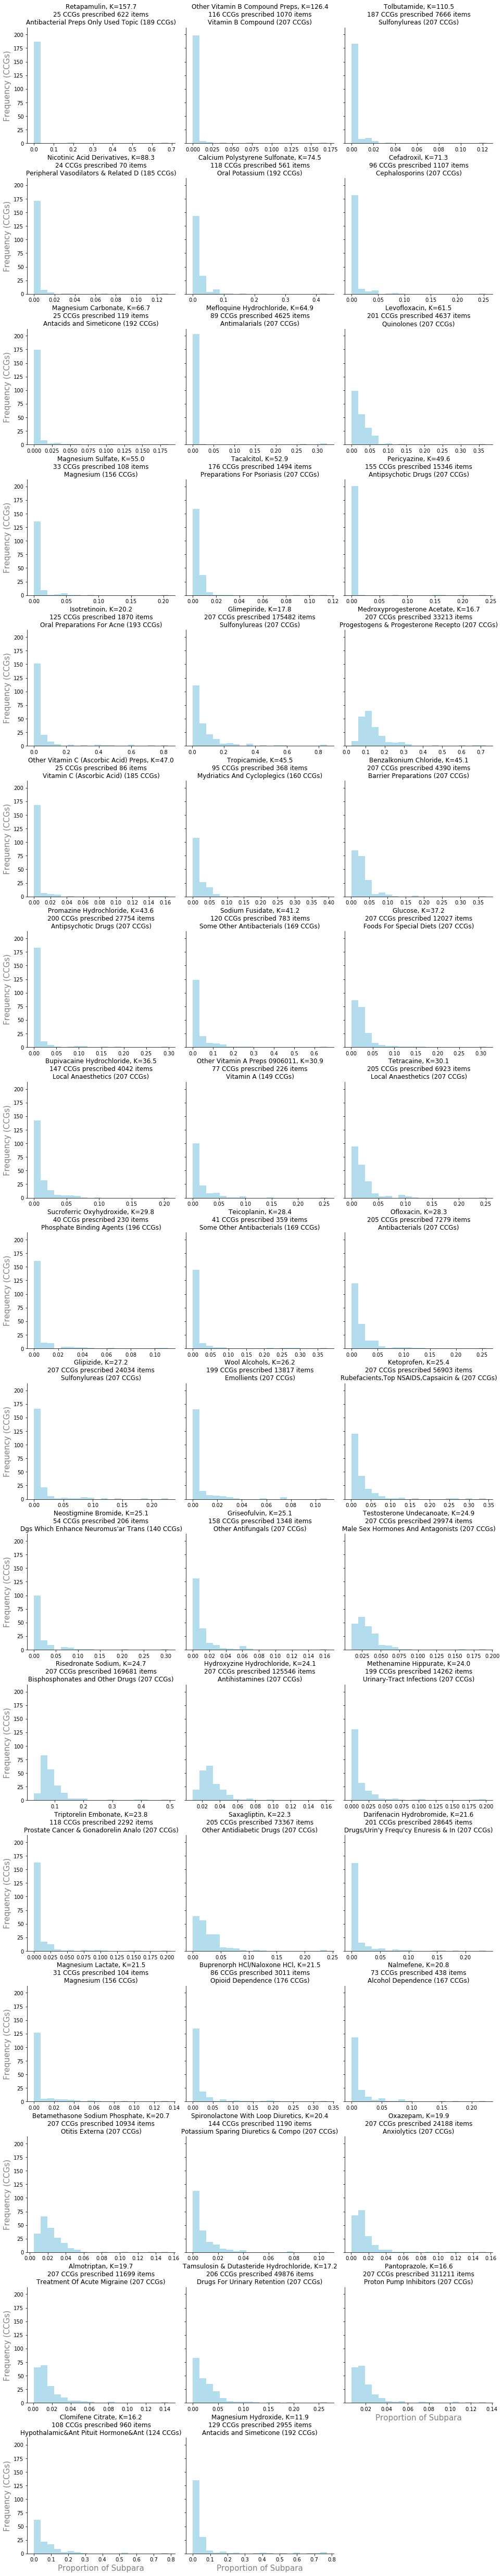

In [39]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name","count","count2","score","kurtosis","num_total"]].head(50).merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+", K="+titles["kurtosis"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"

titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Percentile differences / IQR etc.
First Calculate various percentiles

In [40]:
dftest = df5.transpose()
q = [0.03,0.05,0.25,0.5,0.75,0.95,0.97]
smy0 = dftest.describe(percentiles=q).drop(["count","mean","std"]).transpose()

#calculate IQR
smy0["IQR"] = smy0["75%"]-smy0["25%"] 

smy0.head()

,min,3%,5%,25%,50%,75%,95%,97%,max,IQR
chemical,,,,,,,,,,
0101010C0,0.000000,0.000000,0.00000,0.000000,0.013179,0.058570,0.193023,0.219687,0.340426,0.058570
0101010F0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.019306,0.033701,0.185629,0.000000
0101010G0,0.081081,0.149077,0.16075,0.333333,0.440633,0.590946,0.792278,0.820035,0.912442,0.257613
0101010I0,0.000000,0.000000,0.00000,0.000000,0.016001,0.042445,0.125394,0.159254,0.294872,0.042445
0101010J0,0.000000,0.000000,0.00000,0.008860,0.018857,0.037184,0.080607,0.109442,0.162162,0.028325


### Chemicals with largest ratio of 3-5th percentiles to 5-50th percentiles
This mostly picks out **negatively** skewed distributions

In [41]:
smy = smy0
smy["3-5"] = smy["5%"]-smy["3%"]
smy["5-50"] = smy["50%"]-smy["5%"]
smy["ratio2"] = smy["3-5"]/smy["5-50"]

# merge to data which is limited to chemicals with positive skew
smy = smy.reset_index()
smy = smy[["chemical","ratio2"]].merge(dfp, on="chemical")
smy["M1"]  = smy["ratio2"].rank(ascending=False, method="min")
smy.sort_values(by="ratio2",ascending=False)
#doesn't work this way:
#for x in np.arange(1,10,1): #len(dftest.index)):   
    #pd.qcut(dftest['ratio'].iloc[x], 10)#, labels=np.arange(1,11,1))

,chemical,ratio2,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,M1
11,0102000N0,0.340914,Hyoscine Butylbromide,0102000,Antispasmod.&Other Drgs Alt.Gut Motility,370793.0,10,207.0,207.0,0.31,0.20,0.48,0.28,0.04,0.63,0.30,1.0
31,0202010P0,0.330064,Indapamide,0202010,Thiazides And Related Diuretics,1132162.0,10,207.0,207.0,0.30,0.08,0.56,0.48,0.08,0.45,0.13,2.0
70,0209000A0,0.281905,Aspirin,0209000,Antiplatelet Drugs,6249885.0,10,207.0,207.0,0.71,0.61,0.80,0.19,0.03,0.95,0.09,3.0
357,1203010Q0,0.281527,Lidocaine Hydrochloride,1203010,Drugs For Oral Ulceration & Inflammation,3830.0,5,207.0,199.0,0.01,0.00,0.11,0.11,0.02,4.54,1.82,4.0
332,1108010L0,0.266323,Liquid Paraffin,1108010,"Tear Deficiency,Eye Lubricant/Astringent",155923.0,9,207.0,207.0,0.11,0.02,0.19,0.17,0.03,0.62,0.20,5.0
96,0401010R0,0.242322,Nitrazepam,0401010,Hypnotics,130666.0,9,207.0,207.0,0.06,0.02,0.17,0.15,0.03,1.33,1.16,6.0
401,1310020N0,0.235485,Miconazole Nitrate,1310020,Antifungal Preparations,123262.0,9,207.0,207.0,0.25,0.13,0.42,0.29,0.06,0.08,0.43,7.0
194,0601012V0,0.235201,Insulin Glargine,0601012,Intermediate And Long-Acting Insulins,378227.0,10,207.0,207.0,0.31,0.09,0.56,0.47,0.09,-0.24,0.07,8.0
119,0403030X0,0.225773,Escitalopram,0403030,Selective Serotonin Re-Uptake Inhibitors,252993.0,9,207.0,207.0,0.03,0.00,0.14,0.14,0.02,8.29,1.98,9.0
71,0212000B0,0.220637,Atorvastatin,0212000,Lipid-Regulating Drugs,9514400.0,10,207.0,207.0,0.51,0.38,0.78,0.40,0.06,2.84,1.14,10.0


### Histograms for top chemicals by percentile ratio (3-5th)

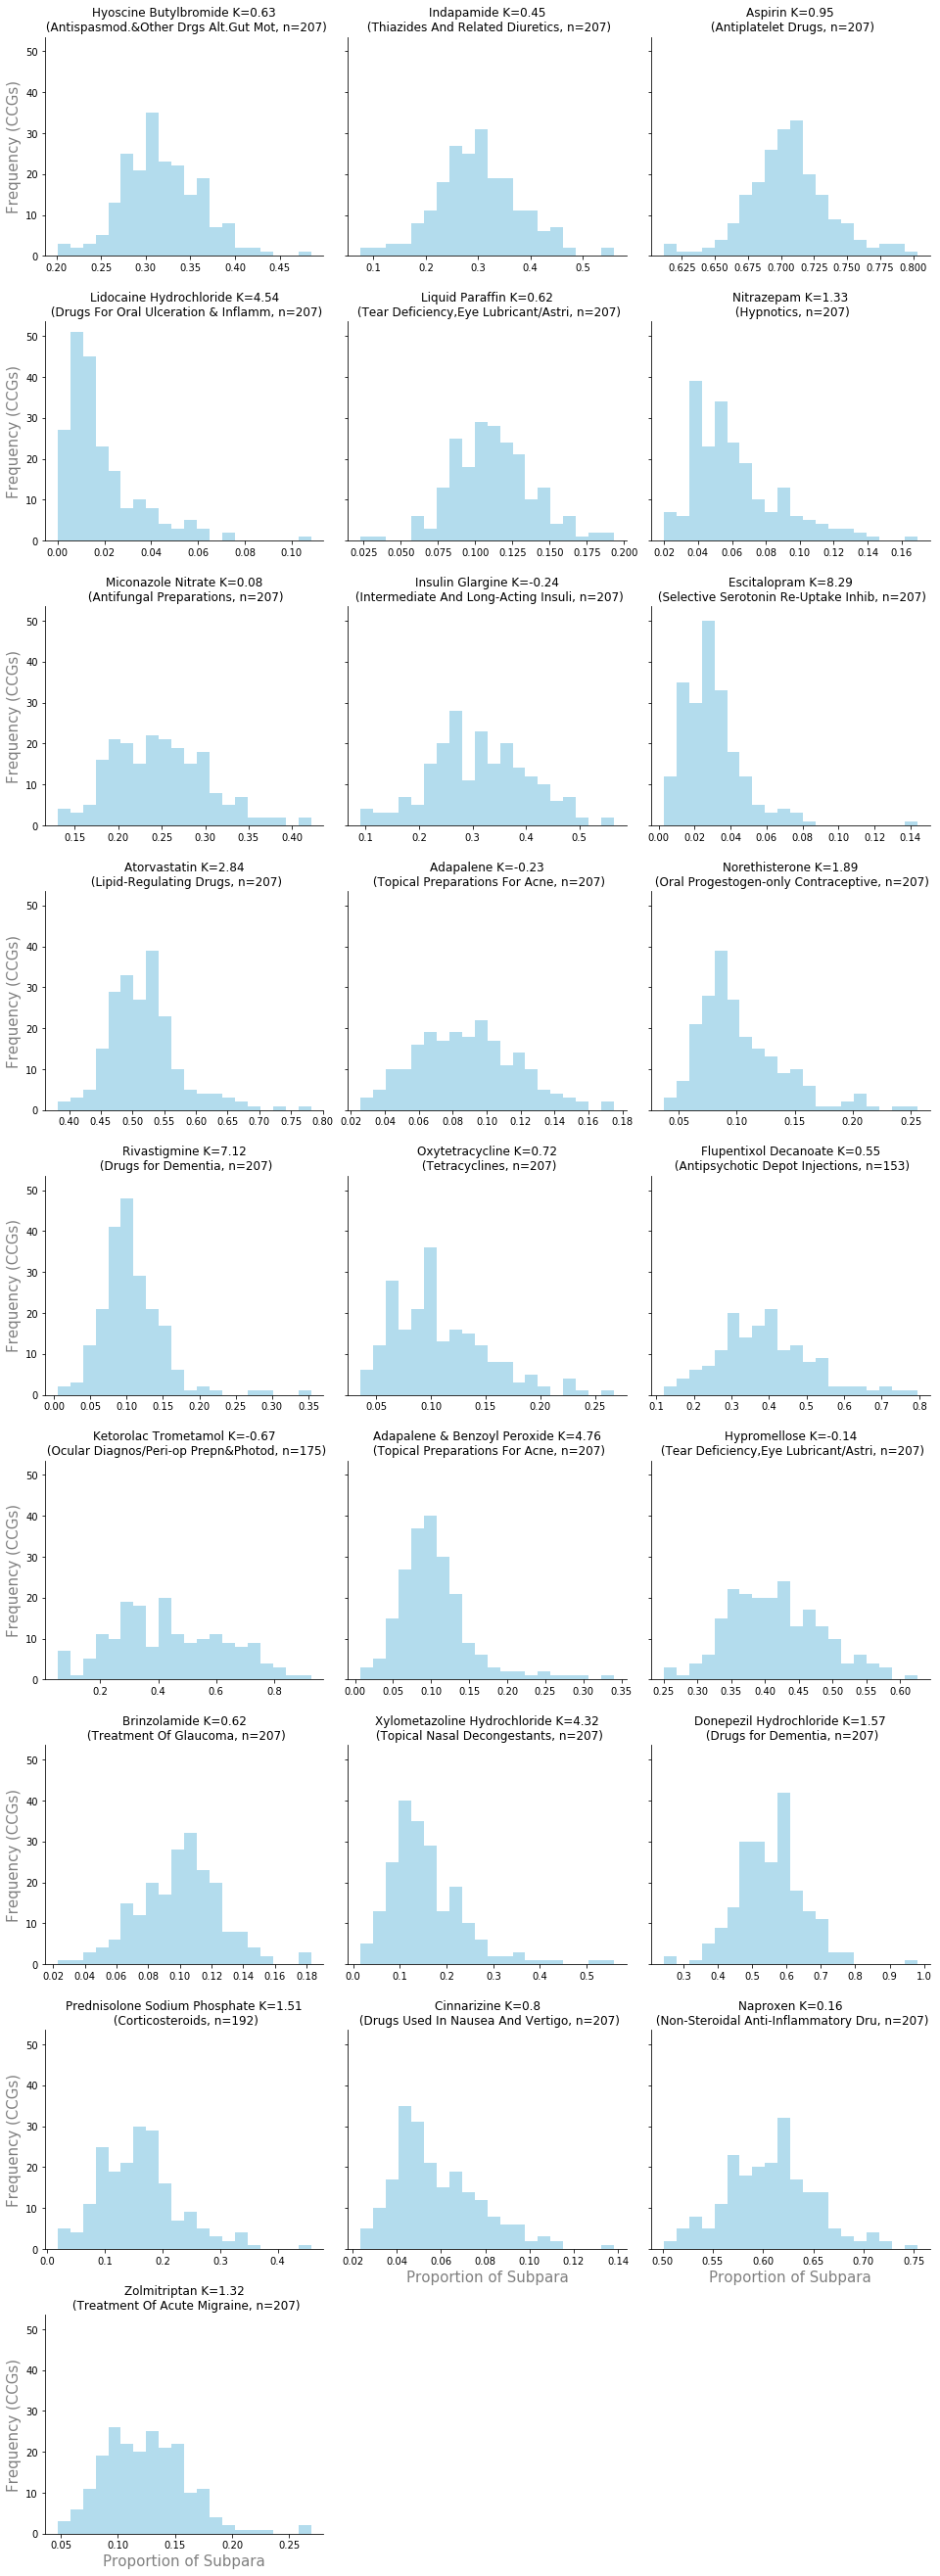

In [42]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with largest ratio of 95-97th percentiles to 50-95th percentiles

In [43]:
smy2 = smy0
smy2["95-97"] = smy2["97%"]-smy2["95%"]
smy2["50-95"] = smy2["95%"]-smy2["50%"]
smy2["ratio2"] = smy2["95-97"]/smy2["50-95"]

smy2 = smy2.reset_index()
smy2 = smy2[["chemical","ratio2"]].merge(dfp, on="chemical")
smy2["M2"]  = smy["ratio2"].rank(ascending=False, method="min")

smy2.sort_values(by="ratio2",ascending=False)


,chemical,ratio2,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,M2
105,0402010S0,1.804282,Promazine Hydrochloride,0402010,Antipsychotic Drugs,27754.0,7,207.0,200.0,0.00,0.00,0.30,0.30,0.03,43.61,6.07,130.0
104,0402010P0,0.880253,Pericyazine,0402010,Antipsychotic Drugs,15346.0,7,207.0,155.0,0.00,0.00,0.24,0.24,0.03,49.60,6.99,342.0
284,090602700,0.871552,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.00,0.17,0.17,0.01,126.43,10.67,342.0
383,1306020J0,0.829108,Isotretinoin,1306020,Oral Preparations For Acne,1870.0,5,193.0,125.0,0.01,0.00,0.83,0.83,0.12,20.18,4.33,342.0
15,0105010D0,0.793457,Balsalazide Sodium,0105010,Aminosalicylates,12836.0,7,207.0,207.0,0.02,0.00,0.13,0.13,0.02,13.59,3.18,325.0
101,0401020T0,0.775810,Oxazepam,0401020,Anxiolytics,24188.0,7,207.0,207.0,0.01,0.00,0.15,0.15,0.02,19.86,4.02,248.0
301,100302010,0.761926,Ketoprofen,1003020,"Rubefacients,Top NSAIDS,Capsaicin & Poul",56903.0,8,207.0,207.0,0.02,0.00,0.34,0.34,0.04,25.41,4.66,152.0
190,0601011P0,0.748109,Insulin Glulisine,0601011,Short-Acting Insulins,21998.0,7,207.0,207.0,0.03,0.00,0.24,0.24,0.03,10.17,2.85,295.0
1,0101010F0,0.745605,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.00,0.00,0.19,0.19,0.02,66.74,7.53,NaN
59,0206040AF,0.736185,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.00,0.13,0.13,0.01,88.27,8.85,NaN


### Histograms for top chemicals by percentile ratio (95-97th)

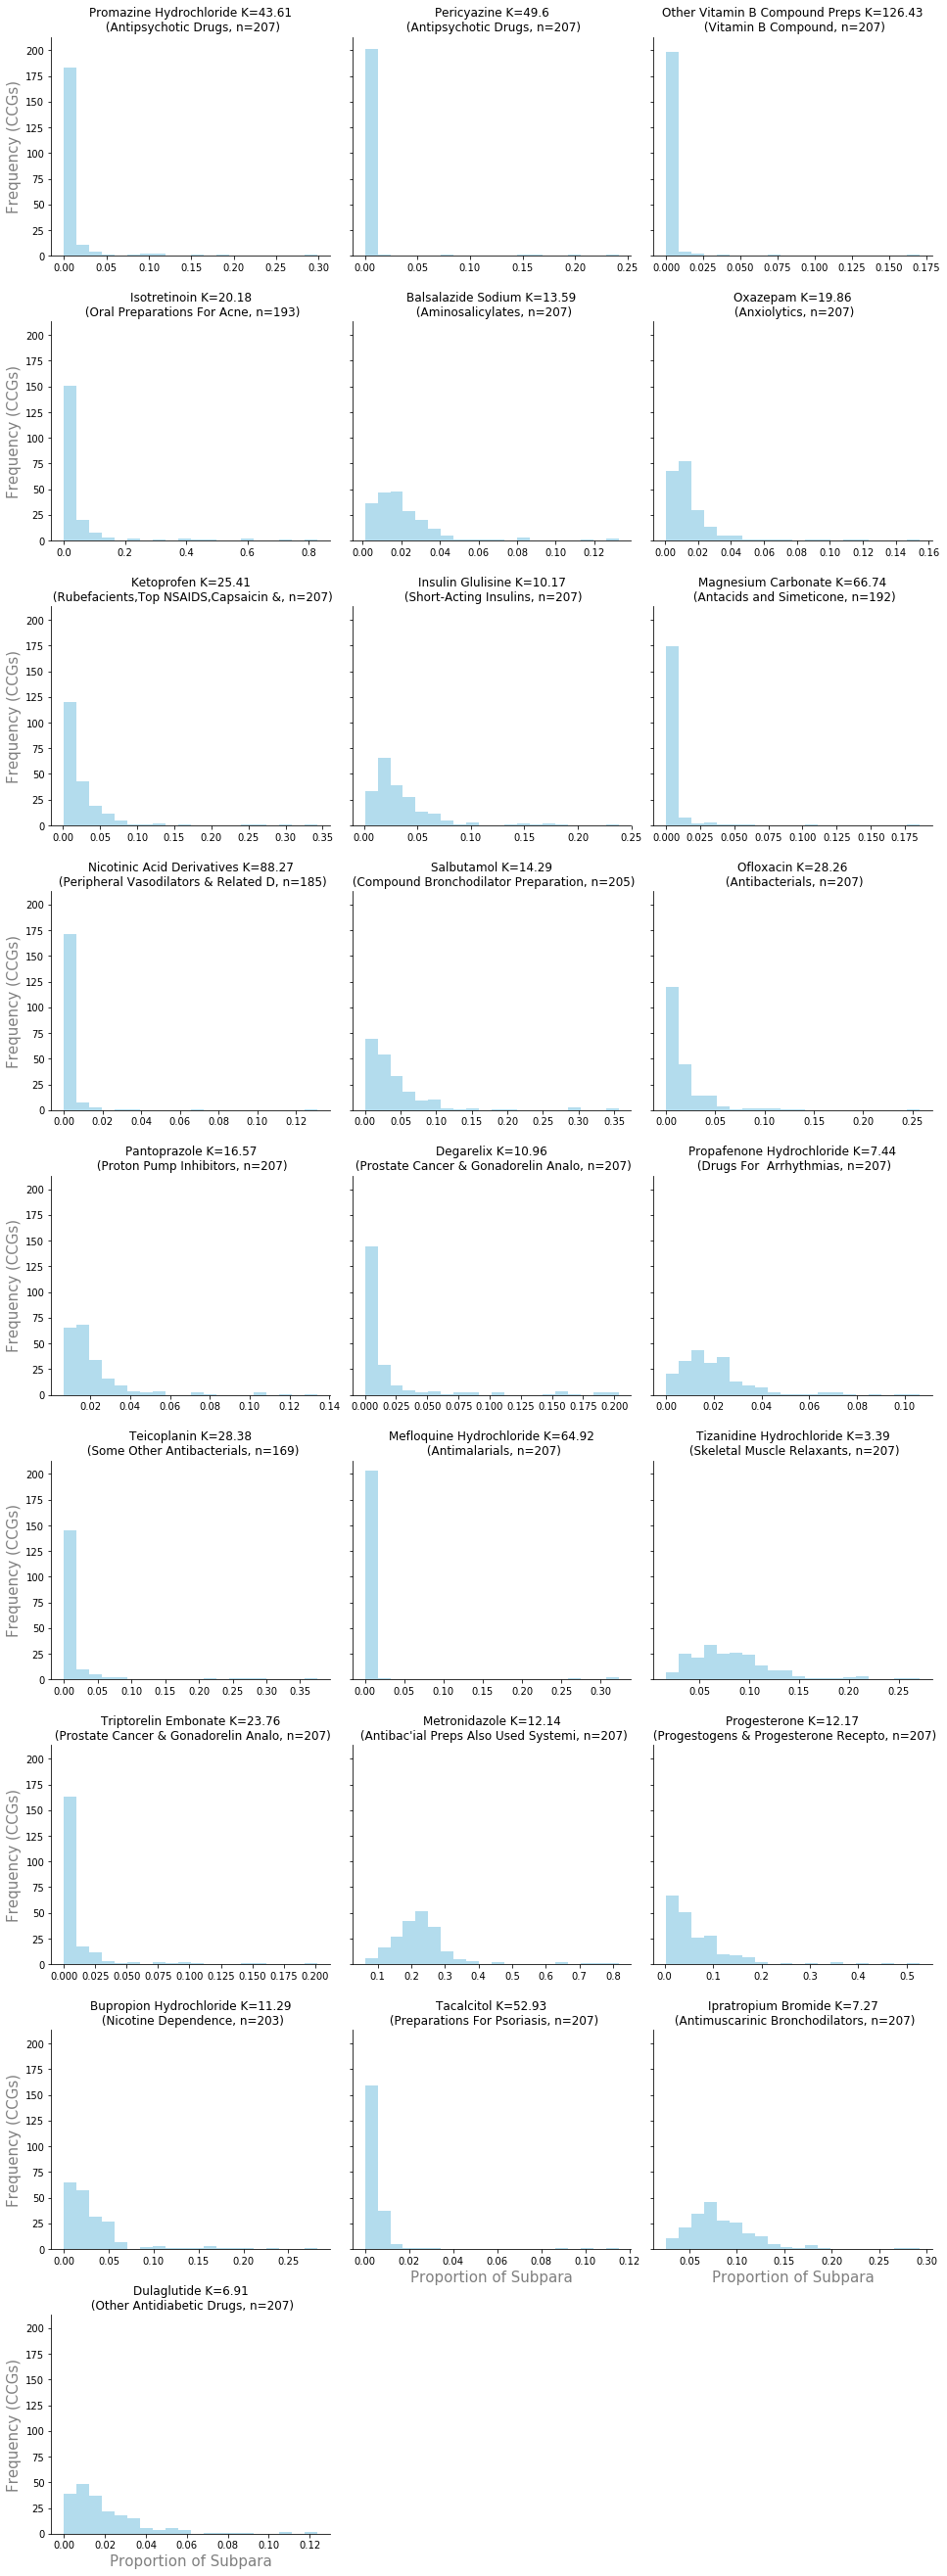

In [44]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy2.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with most CCGs outside IQR*1.5
This is a measure of general disagreement, mostly picks up chemicals with a wide spread of ratio values across CCGs

In [46]:
smy3 = smy0.reset_index()

# join back to dataset (unstacked)
dfx = data3.merge(smy3[["chemical","IQR","25%","75%"]], on="chemical")

#Calculate 1.5* IQR applied to upper and lower quartiles
dfx["1.5xIQR_LQ"] = dfx["25%"]-(dfx["IQR"]/2)
dfx["1.5xIQR_UQ"] = dfx["75%"]+(dfx["IQR"]/2)

#Calculate difference between each ratio and the 1.5IQR limits
dfx["diff_LQ"] = dfx["ratio"]-dfx["1.5xIQR_LQ"]
dfx["diff_UQ"] = dfx["1.5xIQR_UQ"]-dfx["ratio"]

# For each chemical, count how many CCGs are outside 1.5*IQR range
smy3 = dfx.loc[(dfx["diff_UQ"]<0) | (dfx["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values(ascending=False)
smy3 = pd.DataFrame(smy3).reset_index().merge(dfp, on="chemical").rename(columns={"pct":"pct count"})
smy3["M3"]  = smy3["pct count"].rank(ascending=False, method="min")
smy3.head(20)


,chemical,pct count,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,M3
0,0406000J0,52,Domperidone,0406000,Drugs Used In Nausea And Vertigo,123185.0,9,207.0,207.0,0.08,0.03,0.16,0.13,0.02,0.81,0.73,1.0
1,1106000AB,51,Dorzolamide & Timolol,1106000,Treatment Of Glaucoma,166095.0,9,207.0,207.0,0.07,0.02,0.13,0.11,0.02,-0.24,0.49,2.0
2,0802010G0,50,Azathioprine,0802010,Antiproliferative Immunosuppressants,214604.0,9,207.0,207.0,0.83,0.64,1.00,0.36,0.08,-0.11,0.08,3.0
3,0206030Y0,49,Ivabradine,0206030,Other Antianginal Drugs,113719.0,9,207.0,207.0,0.17,0.06,0.48,0.42,0.08,1.33,1.08,4.0
4,1001010J0,49,Ibuprofen,1001010,Non-Steroidal Anti-Inflammatory Drugs,566044.0,10,207.0,207.0,0.18,0.09,0.34,0.24,0.05,0.19,0.53,4.0
5,1306010C0,49,Benzoyl Peroxide,1306010,Topical Preparations For Acne,32906.0,8,207.0,207.0,0.07,0.03,0.23,0.20,0.03,4.89,1.79,4.0
6,0105020A0,49,Budesonide,0105020,Corticosteroids,13397.0,7,192.0,192.0,0.46,0.14,0.84,0.70,0.13,-0.22,0.11,4.0
7,0604020K0,49,Testosterone,0604020,Male Sex Hormones And Antagonists,60182.0,8,207.0,207.0,0.06,0.01,0.20,0.18,0.03,3.55,1.59,4.0
8,0304010D0,48,Loratadine,0304010,Antihistamines,702770.0,10,207.0,207.0,0.17,0.07,0.31,0.24,0.04,0.10,0.48,9.0
9,0209000A0,47,Aspirin,0209000,Antiplatelet Drugs,6249885.0,10,207.0,207.0,0.71,0.61,0.80,0.19,0.03,0.95,0.09,10.0


### Histograms for top 25 chemicals with most CCGs outside 1.5x IQR

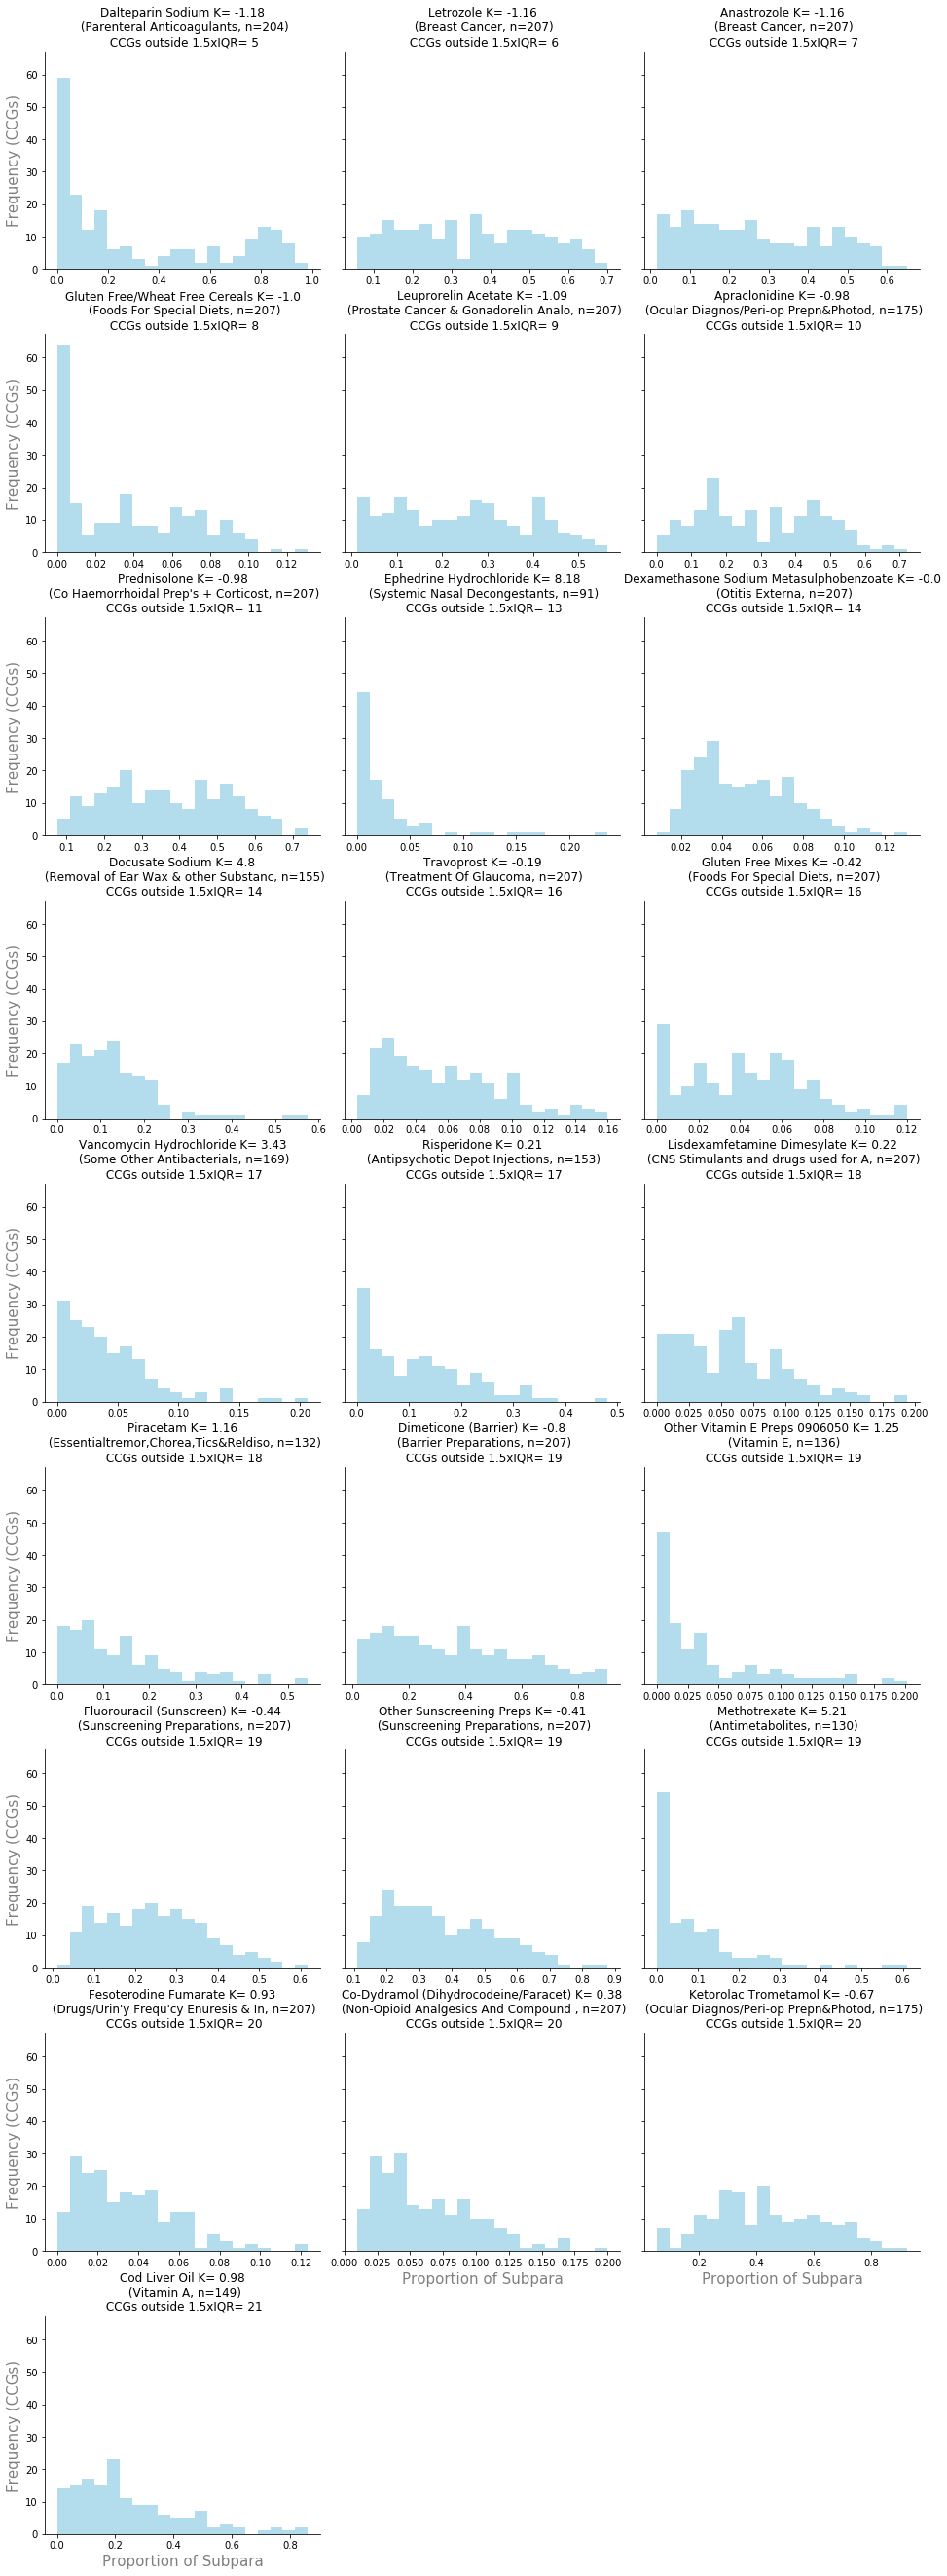

In [47]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy3.sort_values(by="M3",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside 1.5xIQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with with fewest no of CCGs outside IQR
(no of CCGs outside IQR calculated as a proportion of CCGs prescribing items from the subparagraph)

In [48]:
dfx2 = dfx

#Calculate difference between each ratio and the IQR limits
dfx2["diff_LQ"] = dfx2["ratio"]-dfx2["25%"]
dfx2["diff_UQ"] = dfx2["75%"]-dfx2["ratio"]
dfx2

# For each chemical, count how many CCGs are outside IQR range
smy4 = dfx2.loc[(dfx["diff_UQ"]<0) | (dfx2["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values()
smy4 = pd.DataFrame(smy4).reset_index().merge(dfp, on="chemical").rename(columns={"pct":"pct count"})
#calculate no of ccgs as a ratio
smy4["pct ratio"] = smy4["pct count"]/smy4["count"]
#rank:
smy4["M4"]  = smy4["pct ratio"].rank(method="min")
smy4.sort_values(by="pct ratio")


,chemical,pct count,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,pct ratio,M4
1,0206040AF,24,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.00,0.13,0.13,0.01,88.27,8.85,0.129730,1.0
4,0101010F0,25,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.00,0.00,0.19,0.19,0.02,66.74,7.53,0.130208,2.0
3,1310011AA,25,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.00,0.00,0.68,0.68,0.05,157.67,12.36,0.132275,3.0
2,090603100,25,Other Vitamin C (Ascorbic Acid) Preps,0906031,Vitamin C (Ascorbic Acid),86.0,3,185.0,25.0,0.00,0.00,0.16,0.16,0.02,47.02,6.74,0.135135,4.0
6,0905013P0,31,Magnesium Lactate,0905013,Magnesium,104.0,3,156.0,31.0,0.00,0.00,0.13,0.13,0.02,21.47,4.15,0.198718,5.0
15,0905022W0,40,Sucroferric Oxyhydroxide,0905022,Phosphate Binding Agents,230.0,3,196.0,40.0,0.00,0.00,0.11,0.11,0.01,29.76,4.99,0.204082,6.0
7,0905013N0,33,Magnesium Sulfate,0905013,Magnesium,108.0,3,156.0,33.0,0.00,0.00,0.21,0.21,0.02,55.03,6.61,0.211538,7.0
17,0501070T0,41,Teicoplanin,0501070,Some Other Antibacterials,359.0,3,169.0,41.0,0.00,0.00,0.38,0.38,0.05,28.38,5.21,0.242604,8.0
11,090601100,37,Other Vitamin A Preps 0906011,0906011,Vitamin A,226.0,3,149.0,77.0,0.00,0.00,0.25,0.25,0.03,30.94,4.76,0.248322,9.0
12,0402020AB,38,Paliperidone,0402020,Antipsychotic Depot Injections,2384.0,5,153.0,104.0,0.02,0.00,0.34,0.34,0.08,1.85,1.63,0.248366,10.0


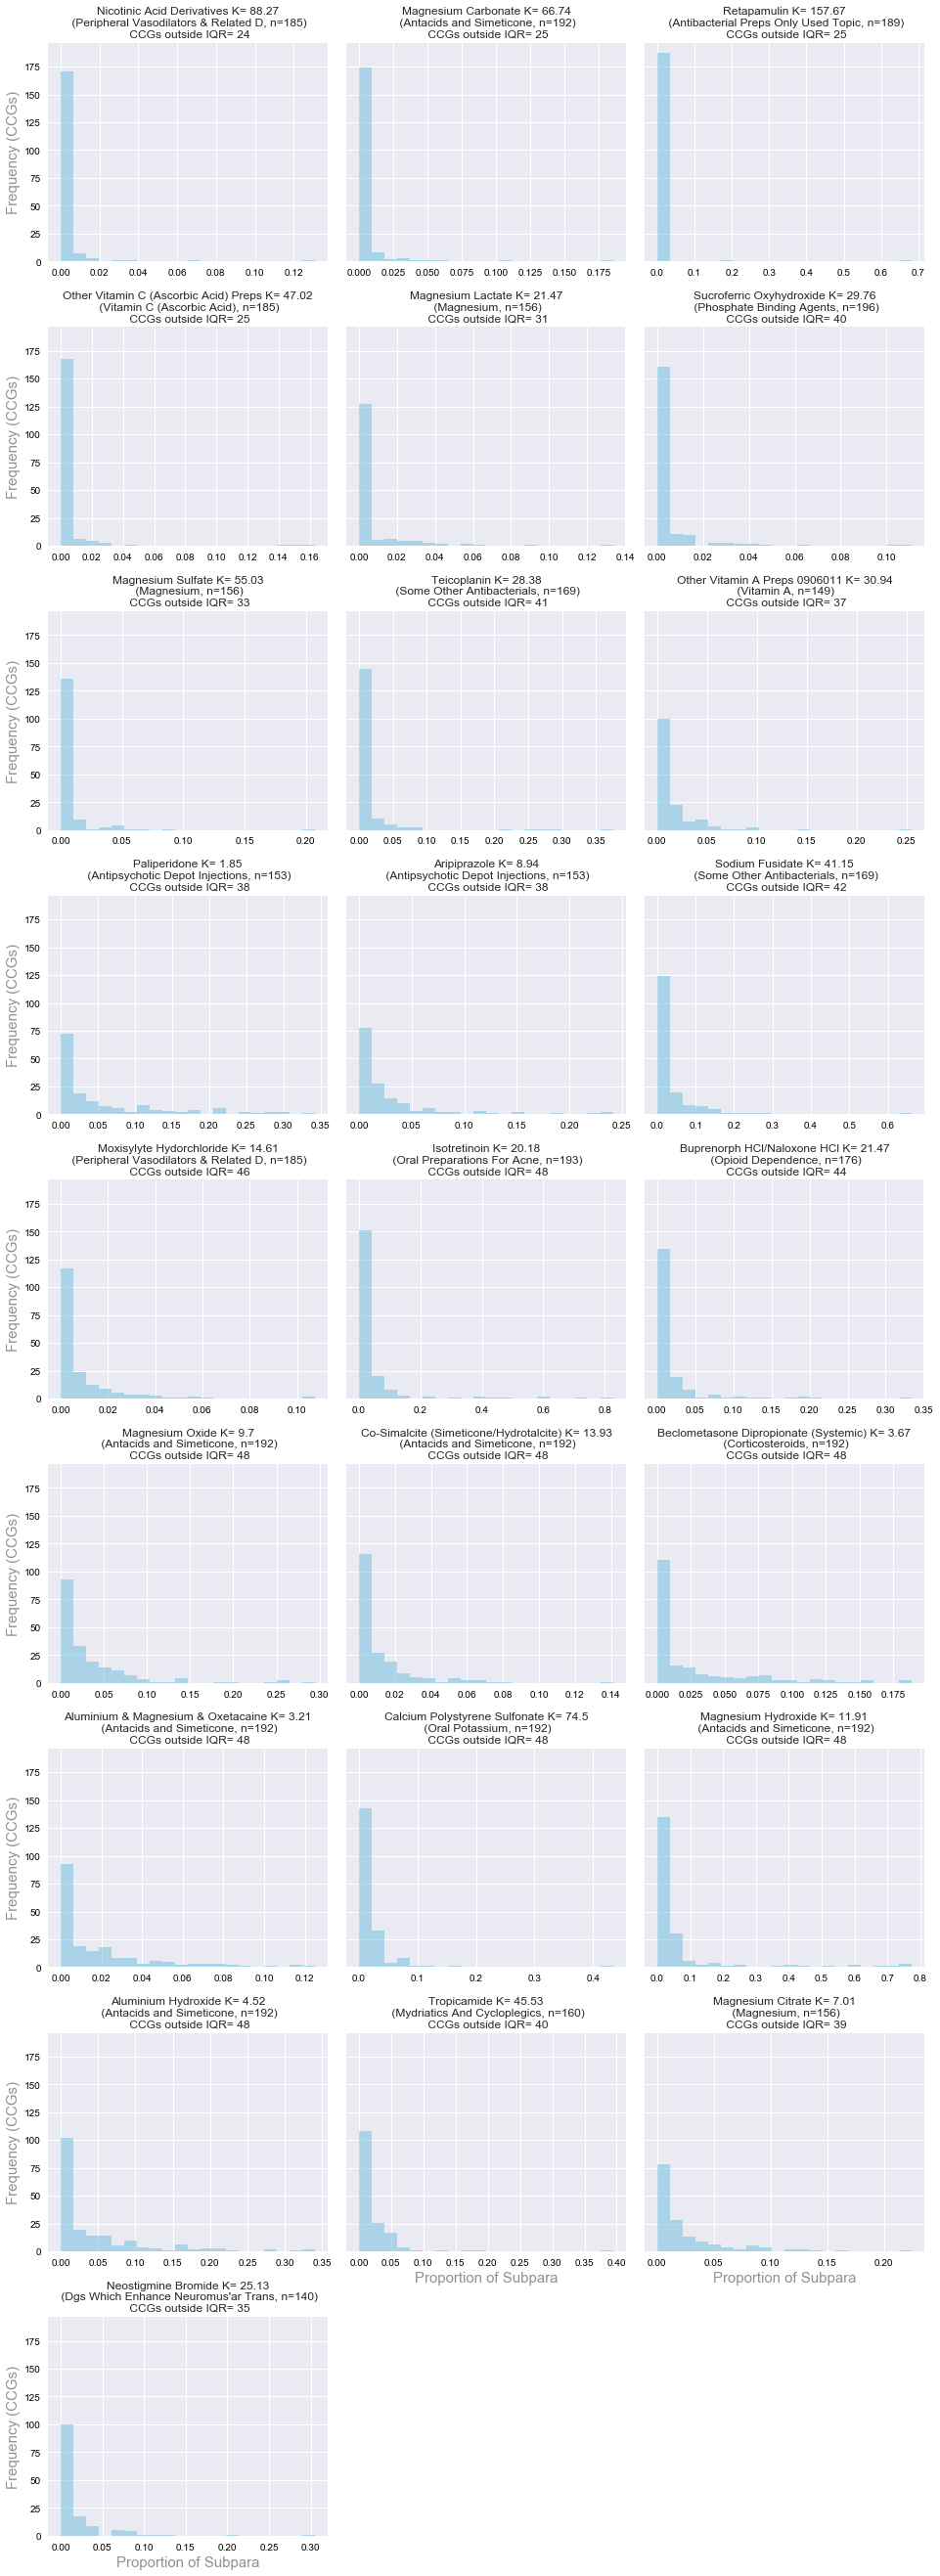

In [17]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy4.sort_values(by="M4",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside IQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with 97th centile at X times IQR from median, ranked by X

In [51]:
smy5 = smy0

smy5["3-50"] = smy5["50%"]-smy5["3%"]
smy5["50-97"] = smy5["97%"]-smy5["50%"]
smy5["ratio1"] = (smy5["3-50"]/smy5["IQR"]).round(2)
smy5["ratio2"] = (smy5["50-97"]/smy5["IQR"]).round(2)

# lower percentiles
smy5a = smy5.sort_values(by="ratio1",ascending=False).reset_index()
smy5a = smy5a[["chemical","ratio1"]].merge(dfp, on="chemical").rename(columns={"ratio1":"percentile ratio"})
smy5a["M5"]  = (smy5a["percentile ratio"].rank(ascending=False, method="min"))

# upper percentiles
smy5b = smy5.sort_values(by="ratio2",ascending=False).reset_index()
smy5b = smy5b[["chemical","ratio2"]].merge(dfp, on="chemical").rename(columns={"ratio2":"percentile ratio"})
smy5b["M5"]  = smy5b["percentile ratio"].rank(ascending=False, method="min")

#smy5c = smy5b.append(smy5a)
smy5b.head(10)

,chemical,percentile ratio,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,M5
0,0206040AF,inf,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.0,0.0,0.13,0.13,0.01,88.27,8.85,1.0
1,090603100,inf,Other Vitamin C (Ascorbic Acid) Preps,0906031,Vitamin C (Ascorbic Acid),86.0,3,185.0,25.0,0.0,0.0,0.16,0.16,0.02,47.02,6.74,1.0
2,0905022W0,inf,Sucroferric Oxyhydroxide,0905022,Phosphate Binding Agents,230.0,3,196.0,40.0,0.0,0.0,0.11,0.11,0.01,29.76,4.99,1.0
3,0905013P0,inf,Magnesium Lactate,0905013,Magnesium,104.0,3,156.0,31.0,0.0,0.0,0.13,0.13,0.02,21.47,4.15,1.0
4,0905013N0,inf,Magnesium Sulfate,0905013,Magnesium,108.0,3,156.0,33.0,0.0,0.0,0.21,0.21,0.02,55.03,6.61,1.0
5,0101010F0,inf,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.0,0.0,0.19,0.19,0.02,66.74,7.53,1.0
6,0501070T0,inf,Teicoplanin,0501070,Some Other Antibacterials,359.0,3,169.0,41.0,0.0,0.0,0.38,0.38,0.05,28.38,5.21,1.0
7,1310011AA,inf,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.0,0.0,0.68,0.68,0.05,157.67,12.36,1.0
8,0402010S0,24.82,Promazine Hydrochloride,0402010,Antipsychotic Drugs,27754.0,7,207.0,200.0,0.0,0.0,0.30,0.30,0.03,43.61,6.07,9.0
9,0501021B0,16.94,Cefadroxil,0501021,Cephalosporins,1107.0,4,207.0,96.0,0.0,0.0,0.25,0.25,0.02,71.29,7.41,10.0


### Histograms for Chemicals with 97th centile at X times IQR from median, ranked by X

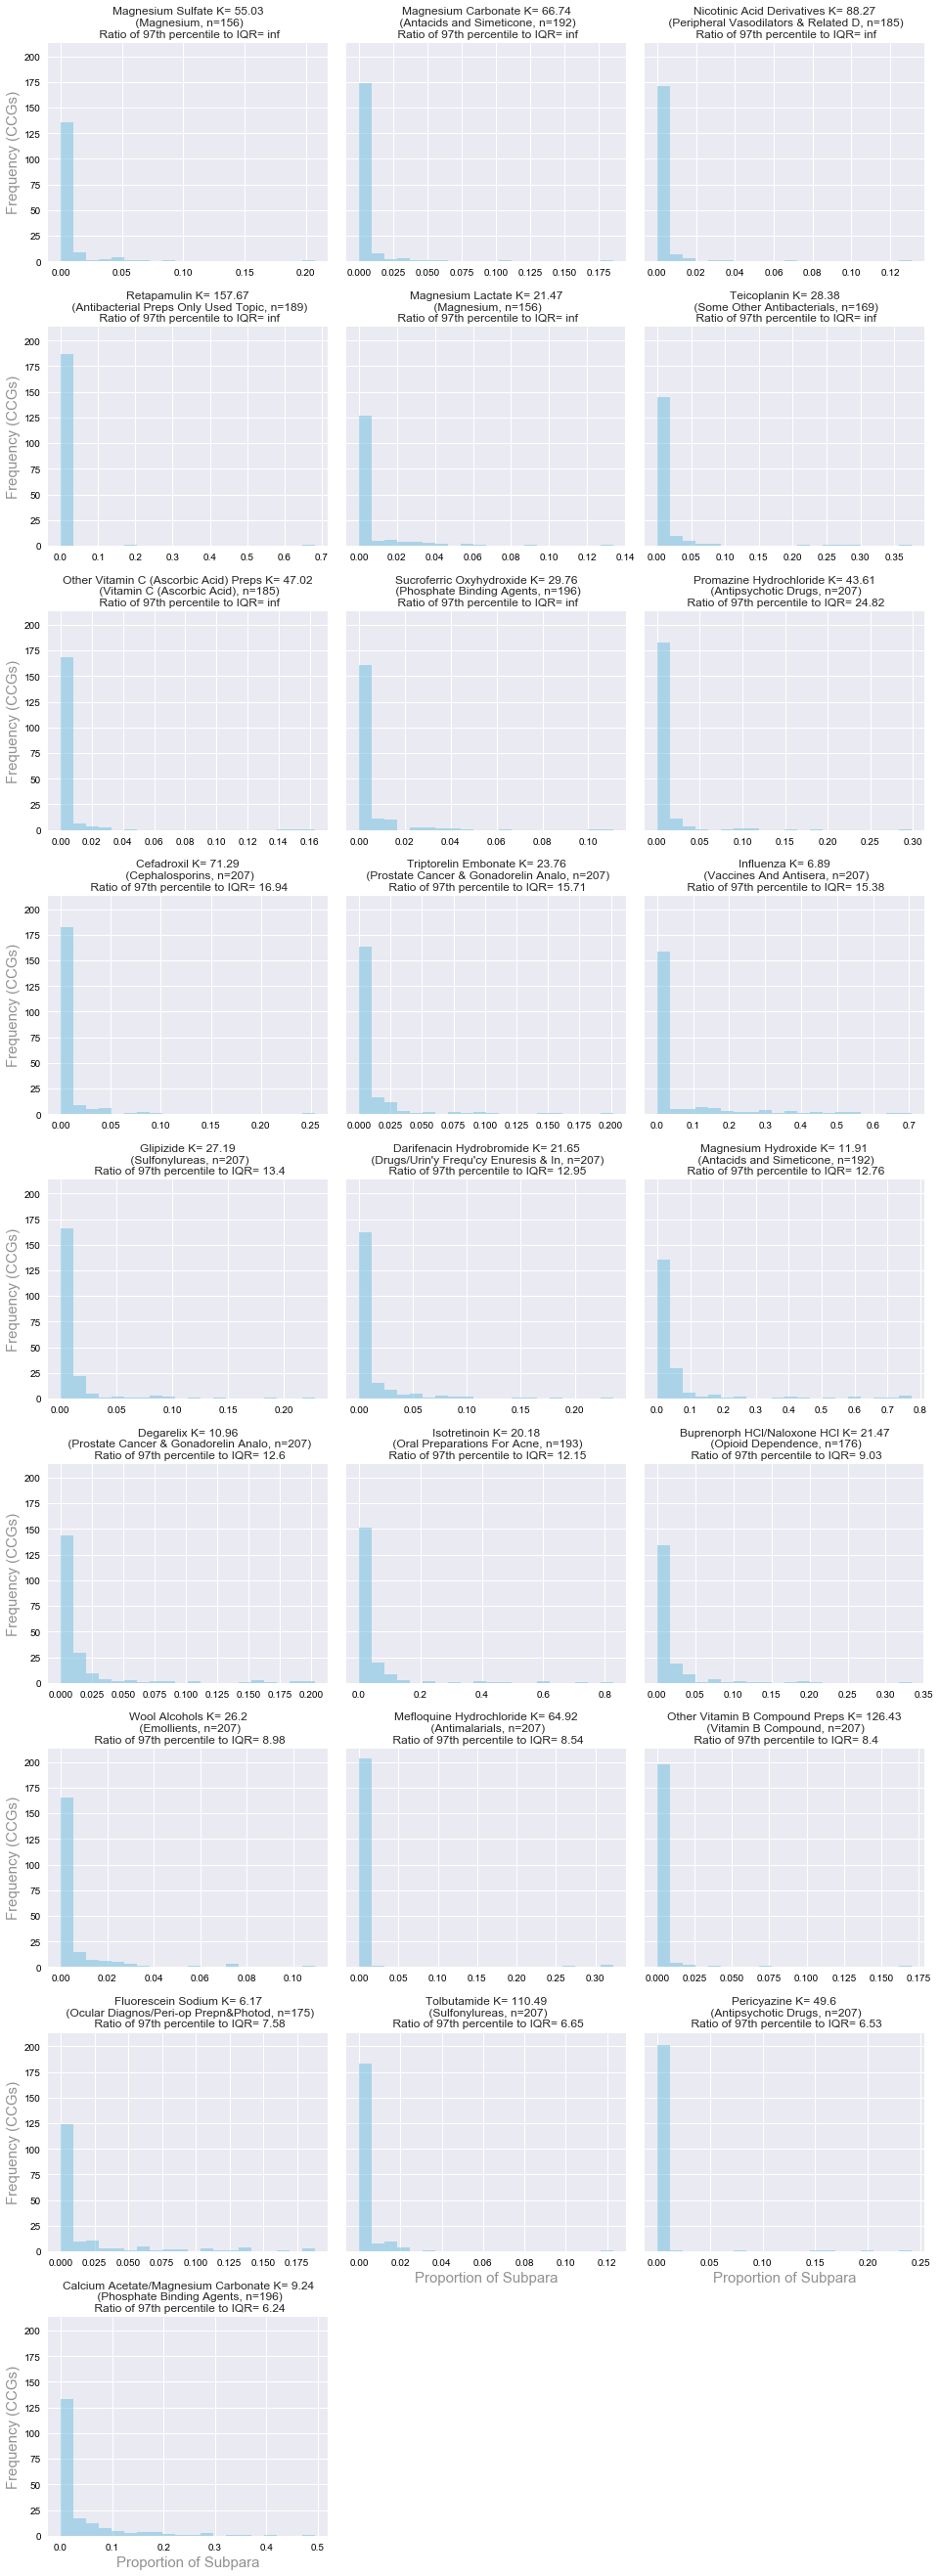

In [19]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy5b.sort_values(by="M5",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","percentile ratio"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","percentile ratio"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Ratio of 97th percentile to IQR= "+titles["percentile ratio"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals where 60% of CCGs prescribe 0 but the total nationally is > X items over 3mo period, ranked by X
Note - chemicals in subparagraphs prescribed by <50 CCGs have been filtered out

In [52]:
smy6 = df4
smy6["ratio_non_p"] = (smy6["count"] - smy6["count2"]) / smy6["count"]
'''smy6 = pd.DataFrame(data3.loc[data3.num==0].groupby("chemical")["pct"].count()).reset_index()
#ct = pd.DataFrame(data3.groupby("chemical")["num"].count()).reset_index()
smy6 = smy6.merge(df4.reset_index(), on="chemical").drop("index",axis=1).rename(columns={"pct":"pct count"})
#smy6 =smy6.merge(ct.reset_index(), on="chemical")
smy6["ratio non-p"] = smy6["pct count"]/smy6["count"]'''

smy6 = smy6.loc[smy6["ratio_non_p"]>0.6].sort_values(by="num_total",ascending=False)
smy6["M6"]  = smy6["num_total"].rank(ascending=False, method="min")
smy6

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,ratio_non_p,M6
306,1502010P0,Mepivacaine HCl,1502010,Local Anaesthetics,1046.0,4,207.0,41.0,0.0,0.0,0.09,0.09,0.01,32.84,5.39,0.801932,1.0
54,0402010C0,Clozapine,0402010,Antipsychotic Drugs,768.0,4,207.0,82.0,0.0,0.0,0.02,0.02,0.00,172.99,12.82,0.603865,2.0
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.0,0.0,0.68,0.68,0.05,157.67,12.36,0.867725,3.0
546,0409010AA,Safinamide,0409010,Dopaminergic Drugs Used In Parkinsonism,526.0,4,207.0,69.0,0.0,0.0,0.01,0.01,0.00,11.75,3.32,0.666667,4.0
297,1001022Y0,Triamcinolone Hexacetonide,1001022,Local Corticosteroid Injections,520.0,4,206.0,33.0,0.0,0.0,0.05,0.05,0.01,36.07,5.75,0.839806,5.0
200,0403040S0,Tryptophan,0403040,Other Antidepressant Drugs,463.0,4,207.0,64.0,0.0,0.0,0.00,0.00,0.00,62.72,6.82,0.690821,6.0
722,1108020K0,Fluorescein Sodium,1108020,Ocular Diagnos/Peri-op Prepn&Photodyn Tt,433.0,4,175.0,63.0,0.0,0.0,0.19,0.19,0.04,6.17,2.59,0.640000,7.0
157,0402010AE,Paliperidone,0402010,Antipsychotic Drugs,431.0,4,207.0,72.0,0.0,0.0,0.01,0.01,0.00,86.67,8.15,0.652174,8.0
446,0208010AB,Fondaparinux Sodium,0208010,Parenteral Anticoagulants,383.0,4,204.0,81.0,0.0,0.0,0.06,0.06,0.01,18.68,3.56,0.602941,9.0
338,0501070T0,Teicoplanin,0501070,Some Other Antibacterials,359.0,3,169.0,41.0,0.0,0.0,0.38,0.38,0.05,28.38,5.21,0.757396,10.0


### Histograms for Chemicals where 60% CCGs prescribe zero
Note - chemicals in subparagraphs prescribed by <50 CCGs have been filtered out

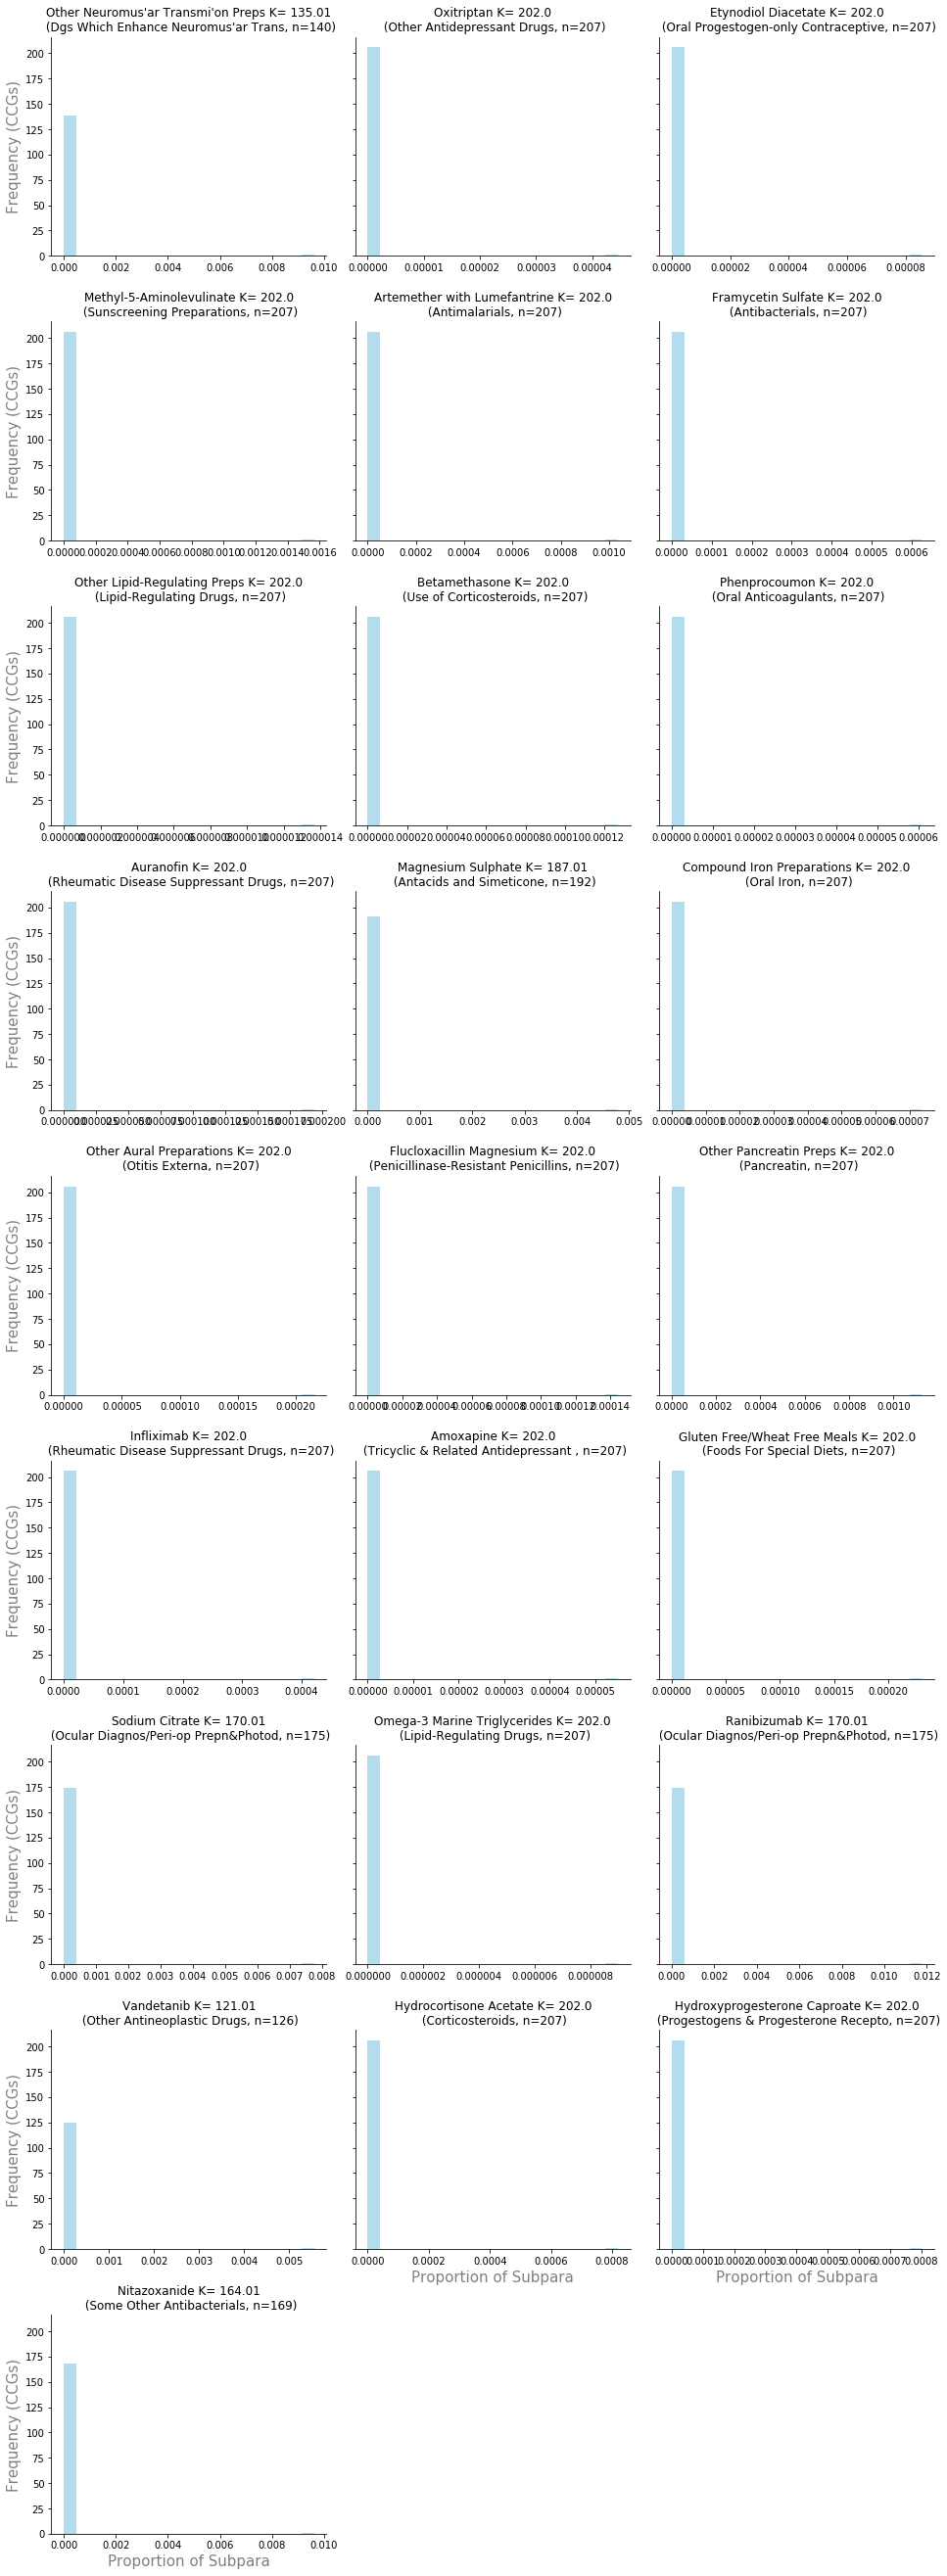

In [53]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy6.sort_values(by="M6",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Compile results

In [56]:
sc = pd.merge(rc, smy[["chemical","kurtosis","range","M1"]], on=["chemical","kurtosis","range"], how="outer")
sc = pd.merge(sc, smy2[["chemical","kurtosis","range","M2"]], on=["chemical","kurtosis","range"], how="outer")#, smy2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
#sc = pd.merge(sc, smy3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy4[["chemical","kurtosis","range","M4"]], on=["chemical","kurtosis","range"], how="outer")#, smy4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy5b[["chemical","kurtosis","range","M5"]], on=["chemical","kurtosis","range"], how="outer")#, smy5b, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy6[["chemical","kurtosis","range","M6"]], on=["chemical","kurtosis","range"], how="outer")#, smy6, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")

sc[['M1','M2','M4','M5','M6']] = sc[['M1','M2','M4','M5','M6']].fillna(0)
sc = df4.merge(sc, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"])

#sc["score"] = sc["score"]+sc["M1"]+sc["M2"]+sc["M4"]+sc["M5"]+sc["M6"]
sc2 = sc
columns = ["R","K","Sk","M1","M2","M4","M5","M6"]
sc2['score'] =0
for col in columns:
    sc2.loc[sc2[col]<=10, 'score'] = sc2['score']+10
    sc2.loc[(sc2[col]>10)&(sc2[col]<=50), 'score'] = sc2['score']+5
sc = sc2.sort_values(by=["score","kurtosis"],ascending=False)
sc = sc.sort_values(by=["score","kurtosis","range"],ascending=False)
sc


links = sc.head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

sc.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,...,ratio_non_p,R,K,Sk,score,M1,M2,M4,M5,M6
0,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.0,0.0,...,0.867725,50.0,1.0,1.0,75,0.0,0.0,3.0,1.0,3.0
5,0501021B0,Cefadroxil,0501021,Cephalosporins,1107.0,4,207.0,96.0,0.0,0.0,...,0.536232,236.0,6.0,8.0,65,0.0,0.0,29.0,10.0,0.0
3,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.0,0.0,...,0.870270,354.0,4.0,4.0,60,0.0,0.0,1.0,1.0,97.0
6,0101010F0,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.0,0.0,...,0.869792,293.0,7.0,6.0,60,0.0,0.0,2.0,1.0,58.0
7,0504010L0,Mefloquine Hydrochloride,0504010,Antimalarials,4625.0,5,207.0,89.0,0.0,0.0,...,0.570048,191.0,8.0,5.0,60,0.0,0.0,29.0,20.0,0.0


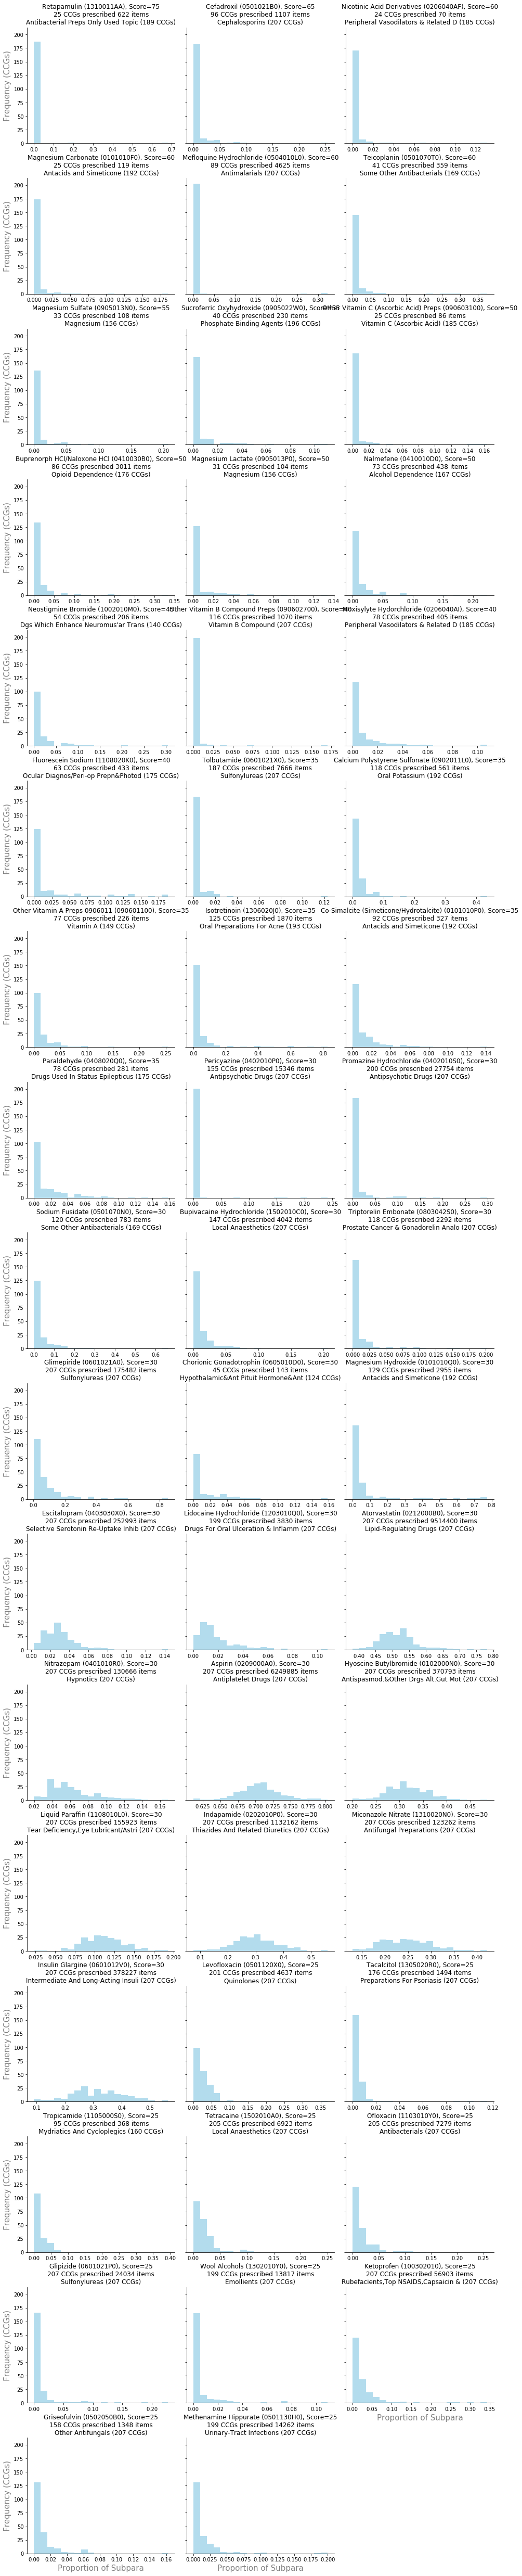

In [57]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = sc.head(50)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","score","count","count2","num_total"]].merge(data3[["chemical","ratio"]], on="chemical")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical","chemical name","subpara name","kurtosis","score","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
#titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Score "+titles["score"].round(1).map(str)
titles["title"] = titles["chemical name"]+" ("+titles["chemical"]+"), Score="+titles["score"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Paragraph Rankings
Which paragraphs occur most often in the list of interesting chemicals?

In [58]:
sc.groupby(["subpara","subpara name"])["score"].agg(["count","sum"]).sort_values(by=["count","sum"],ascending=False).head(20)


,,count,sum
subpara,subpara name,,
0101010,Antacids and Simeticone,10,225
0601023,Other Antidiabetic Drugs,10,110
1106000,Treatment Of Glaucoma,8,110
0402020,Antipsychotic Depot Injections,7,130
0803042,Prostate Cancer & Gonadorelin Analogues,7,110
0601012,Intermediate And Long-Acting Insulins,7,90
0905013,Magnesium,6,170
0501070,Some Other Antibacterials,6,140
1108020,Ocular Diagnos/Peri-op Prepn&Photodyn Tt,6,110


## CCG Rankings
### Ranking CCGs for the list of interesting chems only, by Distance from Median

In [59]:
dftest = sc.head(100)
dftest = dftest[["chemical","chemical name","subpara name","min","max","range","median"]].merge(data3, on="chemical").drop("subpara",axis=1)
dftest = dftest[["chemical","chemical name","subpara name","min","max","range","median","pct","ratio","num","denom_subpara","num_total"]]

dftest["ratio"] = dftest["ratio"].round(2)

#dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
dftest["abs diff"] = abs(dftest["ratio"].round(2)-dftest["median"])/(dftest["max"]-dftest["median"])
dftest["rank abs diff"] = dftest.groupby(["chemical"])["abs diff"].rank(pct=True)
dftest.sort_values(by=["chemical","rank abs diff"])

#x0 = dftest.loc[(dftest["rank abs diff"]<=0.05)]# & (dftest["median"]>0)]
x1 = dftest.loc[(dftest["rank abs diff"]>=0.95)]# & (dftest["median"]<1)] 
x2 = x1#x0.append(x1)
x2 = x2.groupby("pct")["abs diff"].agg(["count","mean"])
x2.sort_values(by=["count","mean"],ascending=False).head(12)



,count,mean
pct,,
02W,14,0.672987
00L,13,0.773026
02R,13,0.679874
10T,13,0.577331
13T,11,0.706245
99C,10,0.709606
08Q,10,0.587156
08M,10,0.448831
07T,9,0.672008


### Investigate example CCG

In [60]:
x3 = x1[["pct","chemical"]].merge(dftest, how="inner", on=["pct","chemical"]).drop(["range"], axis=1)
x3.loc[x3["pct"]=="02W"].sort_values(by=["rank abs diff","abs diff"],ascending=False)

,pct,chemical,chemical name,subpara name,min,max,median,ratio,num,denom_subpara,num_total,abs diff,rank abs diff
413,02W,1105000S0,Tropicamide,Mydriatics And Cycloplegics,0.00,0.39,0.01,0.39,30.0,76.0,368,1.000000,1.000000
266,02W,0601021A0,Glimepiride,Sulfonylureas,0.00,0.85,0.04,0.84,9583.0,11472.0,175482,0.987654,0.995169
407,02W,1305020R0,Tacalcitol,Preparations For Psoriasis,0.00,0.12,0.00,0.10,54.0,528.0,1494,0.833333,0.995169
306,02W,0212000B0,Atorvastatin,Lipid-Regulating Drugs,0.38,0.78,0.51,0.73,28141.0,38358.0,9514400,0.814815,0.995169
640,02W,0606020R0,Risedronate Sodium,Bisphosphonates and Other Drugs,0.03,0.49,0.08,0.41,819.0,2004.0,169681,0.804878,0.995169
113,02W,090602700,Other Vitamin B Compound Preps,Vitamin B Compound,0.00,0.17,0.00,0.07,35.0,495.0,1070,0.411765,0.995169
527,02W,0604012M0,Medroxyprogesterone Acetate,Progestogens & Progesterone Receptor Mod,0.03,0.73,0.12,0.62,396.0,642.0,33213,0.819672,0.990338
535,02W,0103050R0,Pantoprazole,Proton Pump Inhibitors,0.01,0.13,0.02,0.11,2986.0,28242.0,311211,0.818182,0.990338
554,02W,0411000D0,Donepezil Hydrochloride,Drugs for Dementia,0.24,0.98,0.56,0.25,237.0,942.0,513785,0.738095,0.990338
81,02W,0410030B0,Buprenorph HCl/Naloxone HCl,Opioid Dependence,0.00,0.33,0.00,0.17,445.0,2623.0,3011,0.515152,0.977273


## 99P

In [61]:
dftest.loc[dftest["pct"]=="99P"].sort_values(by=["rank abs diff"],ascending=False).head(12)

,chemical,chemical name,subpara name,min,max,range,median,pct,ratio,num,denom_subpara,num_total,abs diff,rank abs diff
7780,0501120X0,Levofloxacin,Quinolones,0.00,0.37,0.37,0.02,99P,0.37,788.0,2136.0,4637,1.000000,1.000000
4980,0803042S0,Triptorelin Embonate,Prostate Cancer & Gonadorelin Analogues,0.00,0.20,0.20,0.00,99P,0.09,332.0,3542.0,2292,0.450000,0.975845
16390,0702020X0,Metronidazole,Vaginal and Vulval Infections,0.01,0.11,0.11,0.03,99P,0.07,266.0,3580.0,8271,0.500000,0.966184
12760,0606020R0,Risedronate Sodium,Bisphosphonates and Other Drugs,0.03,0.49,0.47,0.08,99P,0.17,7025.0,40839.0,169681,0.219512,0.958937
1298,0905013N0,Magnesium Sulfate,Magnesium,0.00,0.21,0.21,0.00,99P,0.04,17.0,436.0,108,0.190476,0.955128
14532,0905022U0,Calcium Acetate/Magnesium Carbonate,Phosphate Binding Agents,0.00,0.49,0.49,0.01,99P,0.21,156.0,742.0,1717,0.416667,0.948980
178,1310011AA,Retapamulin,Antibacterial Preps Only Used Topically,0.00,0.68,0.68,0.00,99P,0.01,5.0,890.0,622,0.014706,0.936508
8768,0601021P0,Glipizide,Sulfonylureas,0.00,0.23,0.23,0.00,99P,0.02,662.0,35221.0,24034,0.086957,0.884058
6538,0209000A0,Aspirin,Antiplatelet Drugs,0.61,0.80,0.19,0.71,99P,0.66,111143.0,168760.0,6249885,0.555556,0.884058
13588,0407041B0,Almotriptan,Treatment Of Acute Migraine,0.00,0.14,0.14,0.01,99P,0.03,475.0,13999.0,11699,0.153846,0.874396


- charts x
- better ccg ranking x
- create table of links x
- change the query so it only limits by subpara >n rather than chemical x
- practice level
- better chemical ranking (logs?)


## Other ways of ranking CCGs / finding odd prescribing
### CCGs ranked in top or bottom 5% for prescribing any chemical

In [63]:
dftest = data3#.head(1000)
dftest

dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
#dftest.groupby(["pct"])["ratio"].sum()
#dftest.loc[dftest["chemical"]=="0101010C0"].sort_values(by=["chemical","rank"])

x = dftest.loc[(dftest["rank"]<=0.05) | (dftest["rank"]>=0.95)]
x2 = x.groupby("pct")["rank"].count()
print (x2.sort_values(ascending=False).head(10))
print (x2.sort_values().head(10))

pct
02W    262
03V    202
08V    188
99C    182
10T    181
03Y    177
07T    165
00N    164
03X    164
03H    161
Name: rank, dtype: int64
pct
06N    47
99H    51
06K    51
99N    52
09Y    54
09G    54
13P    55
06H    55
07H    55
99P    55
Name: rank, dtype: int64
